In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = """
        SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
        """
    return run_query(q)

In [8]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Per genre for USA

In [31]:
q = """
    SELECT 
        sub.Genre, 
        COUNT(sub.Genre) Number_of_Tracks,
        CAST(COUNT(sub.Genre) as float)/
        CAST(
        (SELECT COUNT(track_id) FROM 
            (SELECT il.track_id FROM invoice i
            INNER JOIN invoice_line il
            ON i.invoice_id = il.invoice_id
            WHERE billing_country='USA')) as float) * 100
        AS Perc_of_Total_Tracks
    FROM 
        (SELECT g.name as Genre FROM invoice i
        INNER JOIN invoice_line il
        ON i.invoice_id = il.invoice_id
        INNER JOIN track t
        ON t.track_id = il.track_id
        INNER JOIN genre g
        ON g.genre_id = t.genre_id
        WHERE billing_country='USA') sub
    GROUP BY sub.Genre
    ORDER BY Number_of_Tracks DESC
"""
run_query(q)

,Genre,Number_of_Tracks,Perc_of_Total_Tracks
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


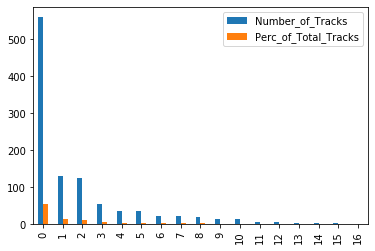

In [30]:
tbl.plot.bar()

From the above study on the number of tracks per genre, the most popular genre is ROCK which contributed more than half of of sales in the US. The runner up goes to PUNK with METAL closely following behind. The top three genres make up the majority (more than 3 quarter) of the tracks sold in the United States. 

## Per sales support agent

In [34]:
q="""
SELECT 
    e.first_name || '-' || e.last_name as "Agent Name", 
    e.hire_date,
    e.birthdate, 
    s.Sales
    FROM employee e 
    INNER JOIN
    (SELECT 
        sub.support_rep_id as employee_id, 
        SUM(sub.unit_price) as Sales
        FROM
            (SELECT c.support_rep_id , il.unit_price FROM customer c
            INNER JOIN invoice i
            ON i.customer_id=c.customer_id
            INNER JOIN invoice_line il
            ON il.invoice_line_id=i.invoice_id) sub
        GROUP BY sub.support_rep_id) as s
    ON s.employee_id=e.employee_id
    ORDER BY s.Sales DESC
"""

run_query(q)

,Agent Name,hire_date,birthdate,Sales
0,Margaret-Park,2017-05-03 00:00:00,1947-09-19 00:00:00,211.86
1,Jane-Peacock,2017-04-01 00:00:00,1973-08-29 00:00:00,209.88
2,Steve-Johnson,2017-10-17 00:00:00,1965-03-03 00:00:00,186.12


In [37]:
q="""
select 
    i.invoice_date, 
    c.support_rep_id from invoice i 
inner join customer c
on c.customer_id=i.customer_id
order by i.invoice_date
limit 10
"""
run_query(q)

,invoice_date,support_rep_id
0,2017-01-03 00:00:00,3
1,2017-01-03 00:00:00,3
2,2017-01-05 00:00:00,4
3,2017-01-06 00:00:00,3
4,2017-01-07 00:00:00,4
5,2017-01-10 00:00:00,5
6,2017-01-12 00:00:00,4
7,2017-01-13 00:00:00,3
8,2017-01-18 00:00:00,3
9,2017-01-18 00:00:00,5


There are three sales support agents in the company. Margaret Park and Jane Peacock had sold more than 200 dollars while Steve Johnson has a bit less. However, considering that Jane and Margaret joined the company 5, 6 months before Steve did, Steve did a pretty good job.

But after looking into the invoice_date, we have found that quite a few invoices were made before they joined the company. Therefore, we have to adjust the query to find out the invoices created during their time of work. Considering those made in the future also belong to the current sales representatives. 

In [36]:
q="""
SELECT 
    e.first_name || '-' || e.last_name as Name, 
    e.hire_date,
    e.birthdate, 
    s.Sales
    FROM employee e 
    INNER JOIN
    (SELECT 
        sub.support_rep_id as employee_id, 
        SUM(sub.unit_price) as Sales
        FROM
            (SELECT 
                c.support_rep_id , 
                il.unit_price
                FROM customer c
                INNER JOIN invoice i
                ON i.customer_id=c.customer_id
                INNER JOIN invoice_line il
                ON il.invoice_line_id=i.invoice_id
                INNER JOIN employee e
                ON c.support_rep_id=e.employee_id
                WHERE e.hire_date<=i.invoice_date
             ) sub
        GROUP BY sub.support_rep_id) as s
    ON s.employee_id=e.employee_id
    ORDER BY s.Sales DESC
"""

run_query(q)

,Name,hire_date,birthdate,Sales
0,Margaret-Park,2017-05-03 00:00:00,1947-09-19 00:00:00,188.10
1,Jane-Peacock,2017-04-01 00:00:00,1973-08-29 00:00:00,187.11
2,Steve-Johnson,2017-10-17 00:00:00,1965-03-03 00:00:00,156.42


Based on the modifed sales numbers, we see the same pattern that Margaret tops the sales chart although she joined the company one month later than Jane. 

## Per country of customers

In [38]:
# c='DROP view temp_customer'
# run_command(c)

c = '''
CREATE VIEW temp_customer AS
     
     SELECT
         country,
         count(customer_id) count
     FROM customer
     GROUP by 1
     ORDER by 2 DESC
'''
run_command(c)

q = 'SELECT * FROM temp_customer;'
run_query(q)

,country,count
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5
4,Germany,4
5,United Kingdom,3
6,Czech Republic,2
7,India,2
8,Portugal,2
9,Argentina,1


In [39]:
q = '''
SELECT
    country,
    count
FROM
    (
    SELECT
        c.country,
        sum(c.count) as count,
        CASE
            WHEN c.country = "Others" THEN 1
            ELSE 0
        END AS sort
    FROM 
        (select 
            case when count=1 
                then "Others"
                else country
            end as country,
            count
        from temp_customer) c
    GROUP BY c.country, sort    
   )

ORDER BY sort ASC, count DESC
'''
run_query(q)

,country,count
0,USA,13
1,Canada,8
2,Brazil,5
3,France,5
4,Germany,4
5,United Kingdom,3
6,Czech Republic,2
7,India,2
8,Portugal,2
9,Others,15
